<a href="https://colab.research.google.com/github/samyff12/LATAM/blob/main/IMAE_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Actualizacion IMAE LATAM**

### Paquetes y meses

In [342]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import urllib.request as urllib2
import re
!pip install pymupdf
!pip install tabula-py
import tabula as tb
import fitz  # this is pymupdf
import matplotlib.pyplot as plt
import seaborn as sns

In [343]:
#html = requests.get('http://www.secmca.org/chart/?parent=Producci%C3%B3n&scid=2&cid=1&scsid=0&son=%C3%8Dndice%20Mensual%20de%20la%20Actividad%20Econ%C3%B3mica&url=11/14/3-13-50-17-4-52-161/39/265/19-258/444/' +
 #                   '20211-20212-20213-20214-20215-20216-20217-20218-20219-202110-202111-202112-20221-20222-20223-20224-20225-20226-20227-20228-20229-202210-202211-202212' +
 #                   '-&all_vars=2|IMAE,%20variaci%C3%B3n%20interanual')
#soup = BeautifulSoup(html.text,'lxml')
#table = soup.find_all('p', class_='text-right')
#tablec = soup.find_all('th', colspan='1')

#indicadores=[]
#paises =[]
#for i in range(len(table)):
 # ind = float(table[i].text)
#  pais = tablec[i].text
#  indicadores.append(ind)
 # paises.append(pais)

#imae_latam =  pd.DataFrame(indicadores,index = paises,columns = ['IMAE'])
#print(f'IMAE a {fecha}')
#imae_latam

In [344]:
meses = [0,[1,'Enero'],[2,'Febrero'],[3,'Marzo'],[4,'Abril'],[5,'Mayo'],[6,'Junio'],[7,'Julio'],[8,'Agosto'],
         [9,'Septiembre'],[10,'Octubre'],[11,'Noviembre'],[12,'Diciembre']]
mes3 = {'ene':'Enero','feb':'Febrero','mar':'Marzo','abr':'Abril','may':'Mayo','jun':'Junio','jul':'Julio',
        'ago':'Agosto','sep':'Septiembre','oct':'Octubre','nov':'Noviembre','dic':'Diciembre'}

### import calendar

# d = dict((v,k) for k,v in enumerate(calendar.month_abbr))
# d

## Para obtener las series de todo el año 2021-2022


### **SECMCA**

In [345]:
html = requests.get('http://www.secmca.org/chart/?parent=Producci%C3%B3n&scid=2&cid=1&scsid=0&son=%C3%8Dndice%20Mensual%20de%20la%20Actividad%20Econ%C3%B3mica&url=11/14/3-13-50-17-4-52-161/39/265/19-258/444/' +
                    '20211-20212-20213-20214-20215-20216-20217-20218-20219-202110-202111-202112-20221-20222-20223-20224-20225-20226-20227-20228-20229-202210-202211-202212' +
                    '-&all_vars=2|IMAE,%20variaci%C3%B3n%20interanual').text
soup = BeautifulSoup(html,'lxml')

In [346]:
import re
tabpais = soup.find_all('th', colspan='1')
table = soup.find_all('p', class_='text-left')
fechas = []
paises =[]
for i in range(len(table)):
  x = re.sub(" ","",table[i].text)
  fechas.append(x.replace("\n",""))
  pais = tabpais[i].text
  #indicadores.append(ind)
  paises.append(pais)
fechas[-1]

'2021-Julio'

In [347]:
table1 = soup.find_all('p', class_='text-right')
matriz = np.array([])
for i in table1:
  matriz = np.array(np.append(matriz,i))
matriz = np.where(matriz=="--", np.nan, matriz).astype(np.float)
matriz = matriz.reshape(-1,7) # 7 paises
imaeLA = pd.DataFrame(matriz,index=fechas,columns=paises)
imaeLA

,Costa Rica,El Salvador,Guatemala,Honduras,Nicaragua,República Dominicana,Panamá
2021-Enero,-6.59,-1.52,1.94,-5.81,0.90,-1.81,-14.63
2021-Febrero,-5.22,-0.79,2.59,-3.09,1.77,1.08,-9.73
2021-Marzo,3.54,9.78,10.14,13.52,7.95,10.60,-6.03
2021-Abril,12.41,28.08,15.23,26.97,15.13,47.13,21.27
2021-Mayo,12.63,31.10,16.30,30.54,15.78,21.21,34.21
2021-Junio,8.88,21.52,13.90,20.93,16.70,12.73,24.91
2021-Julio,14.09,NaN,10.61,NaN,NaN,12.05,NaN


### **Argentina**


#### Publicaciones disponibles las fechas: 
1. 28 sept 
2. 21 Oct
3. 23 Nov
4. 23 Dic

In [348]:
import urllib
url = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_emae_mensual_base2004.xls"
urllib.request.urlretrieve(url, "test.xls")
data = pd.read_excel('test.xls',header=2)
data1 = data.iloc[:,:4].dropna(subset = ['Período'])
data1.reset_index(drop=True,inplace=True)
data1['Unnamed: 0'] = data1['Unnamed: 0'].ffill() # forward fill

In [349]:
data1['fecha'] = data1['Unnamed: 0'].astype('str') +"-"+ data1['Período']
data1.set_index(data1.fecha,inplace=True)
imaeLA = pd.merge(imaeLA,data1.iloc[:,3],how='left',left_index=True,right_index=True)
imaeLA.columns = [*imaeLA.columns[:-1], 'Argentina']
#imaeLA

### **Brasil**

#### Publicaciones :
1. 15 sept
2. 15 Oct
3. 16 Nov
4. 15 Dic

In [350]:
urljson = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.24363/dados?formato=json"
urllib.request.urlretrieve(urljson, "brasil.json")
bra = pd.read_json('brasil.json')
bra['Brasil'] = bra.valor.pct_change(12)*100 # calculo tasa de crecimiento
bra['date'] = pd.to_datetime(bra['data'],format='%d/%m/%Y') # transformamos a formato fecha
# Creamos indice
bra['fecha'] = pd.DatetimeIndex(bra['date']).year.astype(str) +"-"+pd.DatetimeIndex(bra['date']).month.astype(str)

nombre_mes = [meses[i][1] for i in pd.DatetimeIndex(bra['date']).month.tolist()] # obtenemos nombre del mes
bra['fecha'] = pd.DatetimeIndex(bra['date']).year.astype(str) +"-"+ nombre_mes # creamos indice
bra.set_index(bra.fecha,inplace=True) #reemplazamos indice

imaela = pd.merge(imaeLA,bra['Brasil'],how='left',left_index=True,right_index=True) # combinamos la data
bra.tail(1)

,data,valor,Brasil,date,fecha
fecha,,,,,
2021-Julio,01/07/2021,143.35,5.528563,2021-07-01,2021-Julio


In [351]:
# imaela

### **Mexico**

#### Publicaciones disponibles las fechas: 
1. 27 sept 
2. 25 Oct
3. 25 Nov
4. 24 Dic

In [352]:
url = "https://www.inegi.org.mx/contenidos/temas/economia/cn/igae/tabulados/ori/IGAE_2.xlsx"
urllib.request.urlretrieve(url, "test.xlsx")
mex = pd.read_excel('test.xlsx',header=3,nrows=3)
mex = mex.T.reset_index(drop=True) # transponemos y estandarizamos el indice
mex.drop(0,inplace=True) # borramos primera fila
mex[2] = round(mex[2].astype(float),2) # leyendo tasas de crecimiento en el formato numerico y redondeando
mex[0] = mex[0].ffill()

In [353]:
mex[1] = mex[1].replace(['oR','oP','lR','lP','eR','eP'],['o','o','l','l','e','e'], regex=True) #limpiar superindices "Revisado" "Preliminar"
mex[0] = mex[0].replace('P','',regex=True) # limpiar preliminar de fecha
mex.index = mex[0].astype('str') +"-"+ mex[1] #creamos indice para base de datos
mex.columns = [*mex.columns[:-1], 'México'] # nombramos columna
mex.dropna().tail(1) # mostrar ultimo valor no nulo

,0,1,México
2021-Junio,2021,Junio,13.32


In [354]:
imaela = round(pd.merge(imaela,mex['México'],how='left',left_index=True,right_index=True),2) # combinamos las series

In [355]:
# imaela

In [356]:
## link excel
#https://www.inegi.org.mx/contenidos/temas/economia/cn/igae/tabulados/ori/IGAE_1.xlsx       indice

#https://www.inegi.org.mx/contenidos/temas/economia/cn/igae/tabulados/ori/IGAE_2.xlsx       crecimiento

### **Chile**

#### Publicaciones disponibles las fechas:
 
2. 1 Oct  - Agosto
3. 2 Nov  - Septiembre
4. 1 Dic - Noviembre

In [357]:
url = "https://si3.bcentral.cl/estadisticas/Principal1/excel/CCNN/IMACEC/Excel/IMACEC.xlsx"
urllib.request.urlretrieve(url, "chile.xlsx")
df = pd.read_excel('chile.xlsx',header=5,keep_default_na=False)

In [358]:
chile = df.loc[1:,[df.columns[0],df.columns[1],'Imacec']][:-10] # excluimos las ultimas 10 filas (pie de pagina)
chile.rename(columns = {'Imacec':'Chile'}, inplace = True) # renombramos
chile.Chile = pd.to_numeric(chile.Chile).pct_change(12)*100
###
chile[chile.columns[0]] = pd.to_numeric(chile[chile.columns[0]], errors='coerce').ffill().bfill().astype(int)
 # las columnas del excel contienen string en blanco por lo que se transformaron a numero antes de hacer el forward fill
 # el backward fill es para asegurar que no quede NaN por detras y dificulte la creacion del indice
###

chile['mes'] = chile[chile.columns[1]].map(mes3).bfill() # creando mes y usando el bfill por el mismo motivo explicado arriba

#Creamos el indice
chile.index = chile[chile.columns[0]].astype('str') +"-"+ chile.mes

chile.tail(1)

,,Unnamed: 1,Chile,mes
2021-Julio,2021,jul,18.075599,Julio


In [359]:
imaela = round(pd.merge(chile['Chile'],imaela,how='right',left_index=True,right_index=True,sort=True),2).reindex(imaela.index)

In [360]:
imaela

,Chile,Costa Rica,El Salvador,Guatemala,Honduras,Nicaragua,República Dominicana,Panamá,Argentina,Brasil,México
2021-Enero,-2.95,-6.59,-1.52,1.94,-5.81,0.90,-1.81,-14.63,-2.03,-1.19,-5.54
2021-Febrero,-2.02,-5.22,-0.79,2.59,-3.09,1.77,1.08,-9.73,-2.30,0.09,-5.09
2021-Marzo,6.22,3.54,9.78,10.14,13.52,7.95,10.60,-6.03,11.92,5.33,0.83
2021-Abril,14.58,12.41,28.08,15.23,26.97,15.13,47.13,21.27,29.36,16.58,22.34
2021-Mayo,19.18,12.63,31.10,16.30,30.54,15.78,21.21,34.21,13.59,14.33,25.13
2021-Junio,20.61,8.88,21.52,13.90,20.93,16.70,12.73,24.91,10.82,9.01,13.32
2021-Julio,18.08,14.09,NaN,10.61,NaN,NaN,12.05,NaN,NaN,5.53,NaN


### **Ecuador**

#### Publicaciones disponibles las fechas: 
1. 14 sept    -    Julio
2. 13 Oct    -     Agosto
3. 15 Nov    -     Sep
4. 24 Dic    -     Oct

In [361]:
from pandas import errors
url = "https://contenido.bce.fin.ec/documentos/PublicacionesNotas/Catalogo/IEMensual/Adelantos/IEM-452-e.xlsx"
urllib.request.urlretrieve(url, "Ecuador.xlsx")
df = pd.read_excel('Ecuador.xlsx',header=7,keep_default_na=False)[1:13].reset_index()

ecu = (df.set_index(['Unnamed: 0','index'])
.stack()
.reset_index()
.rename(columns={'Unnamed: 0':'mes','level_2':'Year'})).sort_values(['Year','index']) # ingenieria de base de datos

# Elaboracion de indice
ecu['Mes'] = ecu.mes.str.lower().map(mes3)
ecu.index = ecu.Year.astype(str) + '-' + ecu.Mes

# Variacion interanual
ecu['Ecuador'] = pd.to_numeric(ecu[0],errors='coerce').pct_change(12)*100

In [362]:
imaela = round(pd.merge(imaela,ecu['Ecuador'],how='left',left_index=True,right_index=True),2)

df = np.array(tb.read_pdf('ecuador.pdf',pages = '5',stream=True,multiple_tables=True,pandas_options={'header':None}))
dff = pd.DataFrame(df.reshape(-1,5)) # en 2022 el reshape debe ser (-1,6)

dff[dff.iloc[3,2].split(' ')] = dff[2].str.split(' ',expand=True)
if dff.iloc[3,3] in range(2020,2040,1):
  dff[int(dff.iloc[3,3])] = dff[3]
  dff[int(dff.iloc[3,4])] = dff[4]
else:
  dff[int(dff.iloc[3,4])] = dff[4]

if dff.iloc[18,0] in ['Ene']:
    ecu = dff.iloc[18:30,[0,-3,-2,-1]].reset_index(drop=True)
else:
    ecu = dff.iloc[19:31,[0,-3,-2,-1]].reset_index(drop=True)
 
ecu['interanualAnterior'] = ecu.iloc[:,-2].astype(float)/ecu.iloc[:,-3].astype(float)*100-100
ecu['Ecuador'] = ecu.iloc[:,-2].astype(float)/ecu.iloc[:,-3].astype(float)*100-100

listames = [meses[1:][i][1] for i in range(len(meses[1:]))]
ecu['mes'] = listames

ecu.index = str(ecu.columns[-4]) + '-' + ecu.mes
ecu.dropna().tail(1)

### **Colombia**

#### Publicaciones disponibles las fechas: 
1. 17 sept    -    Julio
2. 19 Oct    -     Agosto
3. 16 Nov    -     Sep
4. 17 Dic    -     Oct

In [363]:
url = 'https://www.dane.gov.co/index.php/estadisticas-por-tema/cuentas-nacionales/indicador-de-seguimiento-a-la-economia-ise/historicos-ise-comunicados-y-boletines'

header= {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) ' 
      'AppleWebKit/537.11 (KHTML, like Gecko) '
      'Chrome/23.0.1271.64 Safari/537.11',
      'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
      'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
      'Accept-Encoding': 'none',
      'Accept-Language': 'en-US,en;q=0.8',
      'Connection': 'keep-alive'}

req = urllib2.Request(url=url, headers=header) 
page = urllib2.urlopen(req).read()


In [364]:
soupco = BeautifulSoup(page,'lxml')
links = [a['href'] for a in soupco.select("a[href*=2021]")] # extraemos links que contengan 2021 
 # ultimos link disponibles

In [365]:
url2 = 'https://www.dane.gov.co' + links[0] # si esta el nuevo mes restarle 1 al indice de links
urllib2.urlretrieve(url2, "colombia.pdf")

('colombia.pdf', <http.client.HTTPMessage at 0x7f7134bd85d0>)

In [366]:
# url = 'https://www.dane.gov.co/files/investigaciones/boletines/pib/bol_ISE_' + input('Mes en formato Mmm: ') + '2021.pdf'

# urllib.request.urlretrieve(url, "colombia.pdf")

In [367]:
df = np.array(tb.read_pdf('colombia.pdf',pages = '17',stream=True,multiple_tables=True,pandas_options={'header':None}))
dco = pd.DataFrame(df.reshape(-1,4))
dco = dco.loc[:,0:2]
dco.tail(1)

,0,1,2
31,Junio,"110,05","14,47 8,59"


In [368]:
dco[3] = dco[2].str.split(' ',expand=True)[0] # Tomando las tasas de crecimiento de la tabla pdf
dco['Colombia'] = pd.to_numeric(dco[3].str.replace(',','.'),errors='coerce')  #Convirtiendo la data a numero

In [369]:
split = dco[0].str.split(' - ')     # extraer mes 
fech = []
for i in range(len(split)):
  if type(split[i]) == float:
    fech.append('0')
  elif len(split[i]) == 1 :
    fech.append(str(split[i][0]))
  else:
    fech.append(str(split[i][1].capitalize()))

In [370]:
anof=[]                          # extraer año
for i in range(len(split)):
  if type(split[i]) == float:
    anof.append('0')
  elif len(split[i]) > 1 :
    anof.append(str(split[i][0]))
  else:
    anof.append(np.nan)

In [371]:
dco['mes'] = fech
dco['ano'] = anof
dco['ano'] = dco.ano.replace(['p','r',' '],['','',''],regex=True).ffill()
dco.index = dco['ano'] + '-' + dco['mes'] # creamos indice

In [372]:
imaela = imaela.merge(dco['Colombia'],how='left',left_index=True,right_index=True).reindex(imaela.index)

### **Paraguay**

In [373]:
url = 'https://www.bcp.gov.py/indicador-mensual-de-actividad-economica-del-paraguay-imaep-i471'

#the URL where you are requesting at
req = urllib2.Request(url=url, headers=header) 
page = urllib2.urlopen(req).read()

In [374]:
souppy = BeautifulSoup(page,'lxml')
links = [a['href'] for a in souppy.select("a[href*=_2021]")] # extraemos links que contengan _2021 
 # ultimos link disponibles

In [375]:
#for mes in range(len(links)):
#  linkurl = 'https://www.bcp.gov.py/' + links[-(mes+1)]
#  urllib2.urlretrieve(linkurl, mes)
url2 = 'https://www.bcp.gov.py/' + links[0]
opener = urllib2.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib2.install_opener(opener)
urllib2.urlretrieve(url2, "py.pdf")

('py.pdf', <http.client.HTTPMessage at 0x7f7134acdf10>)

In [376]:
with fitz.open("py.pdf") as doc:
    text = ""
    for page in doc:
        text += page.getText()

fechapy = text.split(' |',2)[1] # con el espacio
fechapy = fechapy.split(' ')[1] +'-'+fechapy.split(' ')[0]
valorpy = text.split('variación de ',1)[1][0:4]
valorpy = float(valorpy.replace(',','.').replace('%',''))
print(fechapy)
valorpy

2021-Julio


3.0

In [377]:
#Añadir nuevo mes cuando salga##IMPORTANTE
py = pd.DataFrame({'Fecha':['2021-Enero','2021-Febrero','2021-Marzo','2021-Abril','2021-Mayo','2021-Junio','2021-Julio'],
                   'Paraguay':[-5.6,-0.5,8.0,19.3,12.4,6.6,3.0]})
dic = {'Fecha':fechapy,'Paraguay':valorpy}
py.append(dic,ignore_index=True)
py.index = py.Fecha

In [378]:
imaela = imaela.merge(py['Paraguay'],how='left',left_index=True,right_index=True).reindex(imaela.index)

In [379]:
#!pip install selenium
#!apt-get update # to update ubuntu to correctly run apt install
#!apt install chromium-chromedriver
#!cp /usr/lib/chromium-browser/chromedriver /usr/bin
#import sys
#sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
#from selenium import webdriver
#chrome_options = webdriver.ChromeOptions()
#chrome_options.add_argument('--headless')
#chrome_options.add_argument('--no-sandbox')
#chrome_options.add_argument('--disable-dev-shm-usage')
#wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

## imae


In [318]:
imaela

,Chile,Costa Rica,El Salvador,Guatemala,Honduras,Nicaragua,República Dominicana,Panamá,Argentina,Brasil,México,Ecuador,Colombia,Paraguay
2021-Enero,-2.95,-6.59,-1.52,1.94,-5.81,0.90,-1.81,-14.63,-2.03,-1.19,-5.54,-8.53,-4.46,-5.6
2021-Febrero,-2.02,-5.22,-0.79,2.59,-3.09,1.77,1.08,-9.73,-2.30,0.09,-5.09,-4.83,-3.73,-0.5
2021-Marzo,6.22,3.54,9.78,10.14,13.52,7.95,10.60,-6.03,11.92,5.33,0.83,13.59,12.38,8.0
2021-Abril,14.58,12.41,28.08,15.23,26.97,15.13,47.13,21.27,29.36,16.58,22.34,56.05,25.98,19.3
2021-Mayo,19.18,12.63,31.10,16.30,30.54,15.78,21.21,34.21,13.59,14.33,25.13,28.98,12.07,12.4
2021-Junio,20.61,8.88,21.52,13.90,20.93,16.70,12.73,24.91,10.82,9.01,13.32,15.95,14.47,6.6
2021-Julio,18.08,14.09,NaN,10.61,NaN,NaN,12.05,NaN,NaN,5.53,NaN,19.27,NaN,3.0


In [380]:
imaela = imaela.reset_index()
imaela

,index,Chile,Costa Rica,El Salvador,Guatemala,Honduras,Nicaragua,República Dominicana,Panamá,Argentina,Brasil,México,Ecuador,Colombia,Paraguay
0,2021-Enero,-2.95,-6.59,-1.52,1.94,-5.81,0.90,-1.81,-14.63,-2.03,-1.19,-5.54,-8.53,-4.46,-5.6
1,2021-Febrero,-2.02,-5.22,-0.79,2.59,-3.09,1.77,1.08,-9.73,-2.30,0.09,-5.09,-4.83,-3.73,-0.5
2,2021-Marzo,6.22,3.54,9.78,10.14,13.52,7.95,10.60,-6.03,11.92,5.33,0.83,13.59,12.38,8.0
3,2021-Abril,14.58,12.41,28.08,15.23,26.97,15.13,47.13,21.27,29.36,16.58,22.34,56.05,25.98,19.3
4,2021-Mayo,19.18,12.63,31.10,16.30,30.54,15.78,21.21,34.21,13.59,14.33,25.13,28.98,12.07,12.4
5,2021-Junio,20.61,8.88,21.52,13.90,20.93,16.70,12.73,24.91,10.82,9.01,13.32,15.95,14.47,6.6
6,2021-Julio,18.08,14.09,NaN,10.61,NaN,NaN,12.05,NaN,NaN,5.53,NaN,19.27,NaN,3.0


In [ ]:
f, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data=imaela.iloc[-2:,:],);

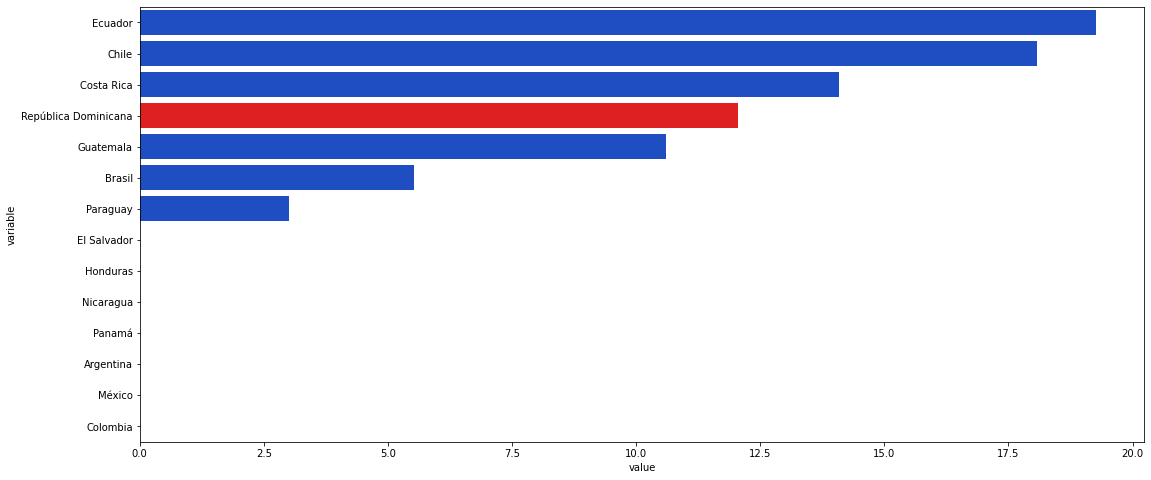

In [424]:
f, ax = plt.subplots(figsize=(18, 8))
df = pd.melt(imaela.iloc[-1:,:],'index').sort_values('value',ascending=False) 
sns.barplot(data = df ,x='value',y='variable',
                palette=["#0343DF" if y!='República Dominicana' else 'r' for y in df.variable]);

In [ ]:
sns.barplot(data = df)

In [ ]:
mask1 = y < 0.5
mask2 = y >= 0.5

plt.bar(x[mask1], y[mask1], color = 'red')
plt.bar(x[mask2], y[mask2], color = 'blue')
plt.show()